In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm

from termcolor import colored

In [2]:
sigmoid = nn.Sigmoid()
bcewithLogitsLoss = nn.BCELoss(reduction='sum')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Process

In [4]:
data = np.genfromtxt("data/bank-note/train.csv", dtype = float, delimiter = ',')
data.shape

(872, 5)

In [5]:
data = np.hstack((np.ones((data.shape[0],1)), data))
data.shape

(872, 6)

In [6]:
train_data = data[:,:-1]
train_label = data[:,-1].astype(int)
train_data.shape, train_label.shape

((872, 5), (872,))

In [7]:
train = torch.tensor(train_data).type(torch.FloatTensor)
label = torch.tensor(train_label).type(torch.LongTensor).reshape(-1,1)

In [8]:
test_ = np.genfromtxt("data/bank-note/test.csv", dtype = float, delimiter = ',')
test_.shape

(500, 5)

In [9]:
test_data = np.hstack((np.ones((test_.shape[0],1)), test_))
test_data.shape

(500, 6)

In [10]:
test__ = test_data[:,:-1]
t__ = test_data[:,-1].astype(int)
test__.shape, t__.shape

((500, 5), (500,))

In [11]:
test = torch.tensor(test__).type(torch.FloatTensor)
t = torch.tensor(t__).type(torch.LongTensor).reshape(-1,1)
t.shape

torch.Size([500, 1])

## Main functions

In [12]:
class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super(Gaussian, self).__init__()
        self.norm   = norm(0,1)
        self.mu_    = mu
        self.rho_   = rho
        self.sigma_ = torch.ones(self.mu_.shape)
        
        
    def sample(self):
        self.eps    = self.norm.sample(self.mu_.shape).type(self.mu_.type()).to(device)
        self.sigma_ = torch.log(1 + torch.exp(self.rho_))
        self.W      = self.mu_ + self.sigma_ * self.eps
        return self.W
            
    def loss(self):
        return (0.5*self.mu_**2 + 0.5*self.sigma_ - 0.5*torch.log(1e-20 + self.sigma_)).sum()

In [13]:
class Blinear(nn.Module):
    def __init__(self, n_input, n_output):
        super(Blinear, self).__init__()
        
        

        
        self.n_input  = n_input
        self.n_output = n_output
        scale = 1.0/np.sqrt(2*self.n_input)
        
        
        
#         self.mu       = nn.Parameter(scale*torch.randn(n_output, n_input))
        
        
        
#         self.rho      = nn.Parameter(scale * torch.ones(n_output, n_input))
        
#         self.W        = Gaussian(self.mu, self.rho)

#         self.b_mu     = nn.Parameter(torch.zeros(n_output))
#         self.b_rho    = nn.Parameter(scale * torch.ones(n_output))
#         self.b        = Gaussian(self.b_mu, self.b_rho)
        
        
        
        
        self.mu    = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .05))  # or .01
        self.rho   = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        
        self.W     = Gaussian(self.mu, self.rho)
        
        self.b_mu  = nn.Parameter(torch.Tensor(n_output).normal_(0., .05))
        self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))
        
        self.b     = Gaussian(self.b_mu, self.b_rho)
        
        
        
    def forward(self, x, test_mode = False):
        
        if test_mode:
            W = self.mu
            b = self.b_mu
        else:
            W = self.W.sample()
            b = self.b.sample()
        
        return F.linear(x, W, b)

In [14]:
class BNet(nn.Module):
    
    def __init__(self, layers, act):
        super(BNet, self).__init__()
        
        self.act = act
        self.fc  = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc.append(Blinear(layers[i], layers[i+1]))  
            
            
    def forward(self, x, test_mode = False):
        for i in range(len(self.fc) - 1):
            x = self.fc[i].forward(x, test_mode) #forward based on Blinear 
            x = self.act(x)
        x = sigmoid(self.fc[-1].forward(x, test_mode))
        return x

In [15]:
class BNN():
    def __init__(self, x, y, layers, act, n_epochs = 10000):
        
        self.x = x
        self.y = y.type(torch.float)
        self.n_layers = len(layers)
        
        self.nepochs = n_epochs
        self.BNet    = BNet(layers, act)
        self.hist_acc = []
        self.hist_llh_test = []
        self.hist_llh_train = []
        
    def get_neg_elbo(self):
        neg_elbo = 0
        for i in range(self.n_layers-1):
            neg_elbo += self.BNet.fc[i].W.loss()
            neg_elbo += self.BNet.fc[i].b.loss()
        p_pred = self.BNet(self.x)
        
#         return neg_elbo + bcewithLogitsLoss(p_pred, self.y) 
        return neg_elbo - (torch.log(1e-10 + p_pred[self.y == 1])).sum() - (torch.log(1e-10 + 
                                                                                     1 - p_pred[self.y==0])).sum()
    
    def train(self, lr, decay, step_size = 1000):
    
        optimizer = torch.optim.Adam(self.BNet.parameters(), lr = lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=decay)
        
        for n in range(self.nepochs):
            
            
            with torch.no_grad():
                
                t_pred   = self.BNet(test, test_mode = True)
                
                ll_test  = ((torch.log(1e-7 + 1 - t_pred[t==0])).sum() + 
                            (torch.log(1e-7 + t_pred[t==1])).sum())/t_pred.shape[0]
                
                t_hat    = (t_pred>=0.5).type(torch.DoubleTensor)
                
                acc      = ((t_hat == t).type(torch.DoubleTensor)).sum()/t_pred.shape[0]
                
                p_pred   = self.BNet(self.x, test_mode = True)
                
                ll_train = ((torch.log(1e-7 + 1 - p_pred[self.y==0])).sum() + 
                            (torch.log(1e-7 + p_pred[self.y==1])).sum())/p_pred.shape[0]
                
                
                self.hist_acc.append(acc)
                self.hist_llh_test.append(ll_test)
                self.hist_llh_train.append(ll_train)
                
                
                
            
            loss = self.get_neg_elbo()
            if n == 999:
                with torch.no_grad():
                    print('Loss: ', loss.item())
                    acc = 0
                    pl = 0
                    for i in range(1000):
                        p_pred = self.BNet(self.x)#.numpy()
                        L = self.y.numpy().astype(int)
                        pl += ((torch.log(1e-7 + 1 - p_pred[L==0])).sum() + 
                               (torch.log(1e-7 + p_pred[L==1])).sum())/p_pred.shape[0]
                        y_hat = (p_pred.numpy()>=0.5).astype(int)
                        acc += (L == y_hat).astype(int).mean()
                    
                    print(colored('learning rate:{}'.format(optimizer.param_groups[0]['lr']), 'blue'))
                    print(colored('Train accuracy for iteration {} is {}'.format(n, acc/1000), 'red'))
                    print('Predictive log-likelihood for train at iteration {} is {}'.format(n, pl/1000))
                    
                    
                    acc = 0
                    pl = 0
                    for i in range(1000):
                        L_t = t.numpy().astype(int)
                        t_pred = self.BNet(test)#.numpy()   
                        pl += ((torch.log(1e-7 + 1 - t_pred[L_t==0])).sum() + 
                               (torch.log(1e-7 + t_pred[L_t==1])).sum())/t_pred.shape[0]
                        t_hat = (t_pred.numpy()>=0.5).astype(int)
                        acc += (L_t == t_hat).astype(int).mean()
                    print('Test accuracy is {}'.format(acc/1000))
                    print('Predictive log-likelihood for test at iteration {} is {}'.format(n, pl/1000))
                    
                    
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            scheduler.step()
            


In [16]:
def _plot_(x, title):
    plt.plot(x)
    plt.title(title)
    plt.show()

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  247.15057373046875
learning rate:0.001
Train accuracy for iteration 999 is 0.9976685779816538
Predictive log-likelihood for train at iteration 999 is -0.010052332654595375
Test accuracy is 0.9966440000000019
Predictive log-likelihood for test at iteration 999 is -0.012576242908835411


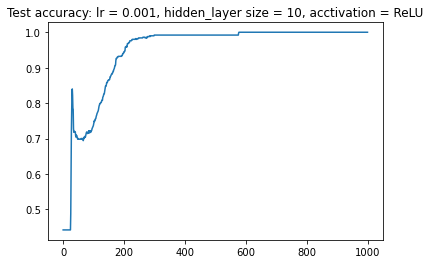

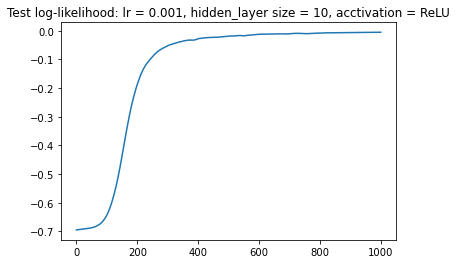

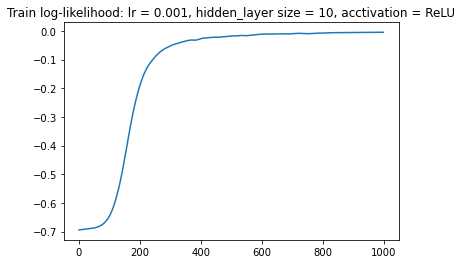

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  684.4873657226562
learning rate:0.001
Train accuracy for iteration 999 is 0.9965928899082611
Predictive log-likelihood for train at iteration 999 is -0.010937577113509178
Test accuracy is 0.9958940000000023
Predictive log-likelihood for test at iteration 999 is -0.01242478284984827


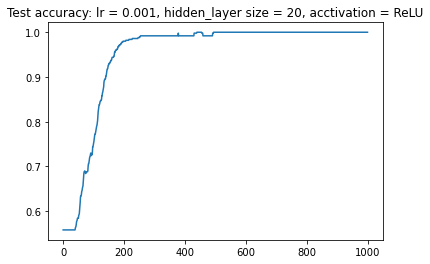

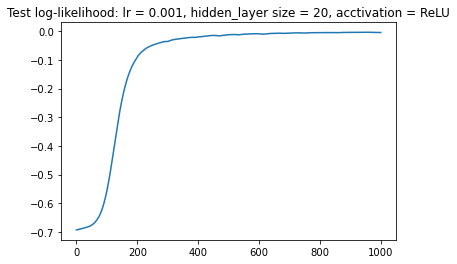

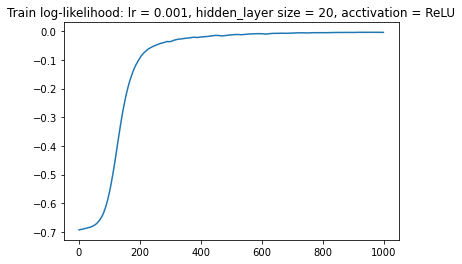

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  3307.718994140625
learning rate:0.001
Train accuracy for iteration 999 is 0.9972832568807376
Predictive log-likelihood for train at iteration 999 is -0.009694854728877544
Test accuracy is 0.9968400000000025
Predictive log-likelihood for test at iteration 999 is -0.010710174217820168


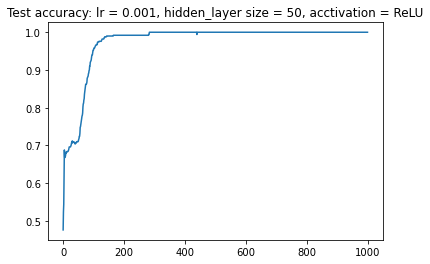

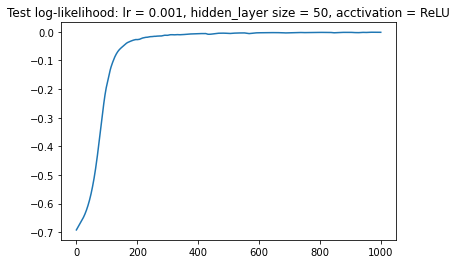

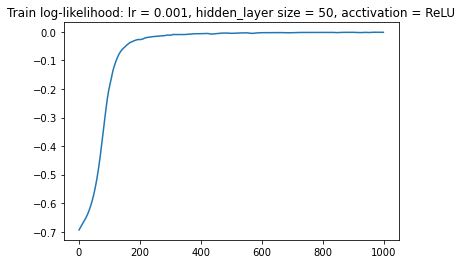

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  276.272216796875
learning rate:0.0005
Train accuracy for iteration 999 is 0.9932626146789011
Predictive log-likelihood for train at iteration 999 is -0.02624715119600296
Test accuracy is 0.9920399999999999
Predictive log-likelihood for test at iteration 999 is -0.029641684144735336


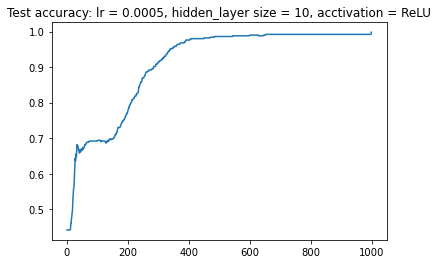

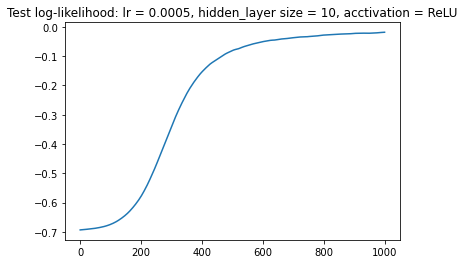

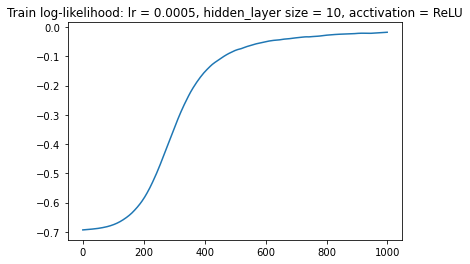

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  781.6354370117188
learning rate:0.0005
Train accuracy for iteration 999 is 0.9951100917431216
Predictive log-likelihood for train at iteration 999 is -0.017509084194898605
Test accuracy is 0.9942859999999999
Predictive log-likelihood for test at iteration 999 is -0.019899945706129074


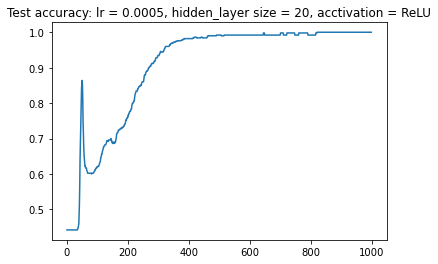

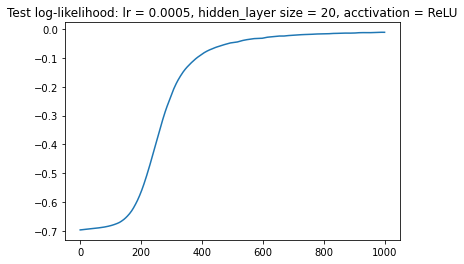

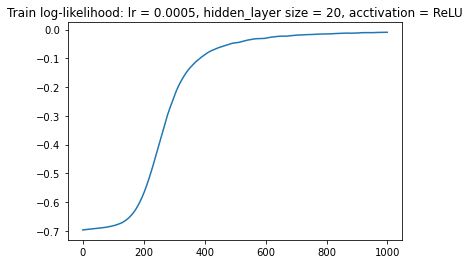

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  3863.73388671875
learning rate:0.0005
Train accuracy for iteration 999 is 0.996811926605508
Predictive log-likelihood for train at iteration 999 is -0.011918419972062111
Test accuracy is 0.9960540000000043
Predictive log-likelihood for test at iteration 999 is -0.014215503819286823


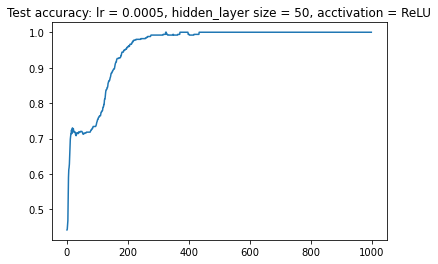

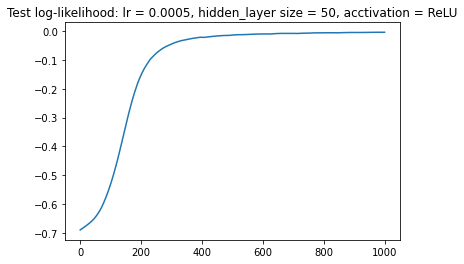

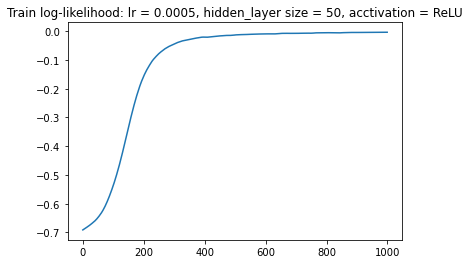

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  797.9082641601562
learning rate:0.0001
Train accuracy for iteration 999 is 0.5714128440367031
Predictive log-likelihood for train at iteration 999 is -0.5895403027534485
Test accuracy is 0.5777259999999962
Predictive log-likelihood for test at iteration 999 is -0.5902348160743713


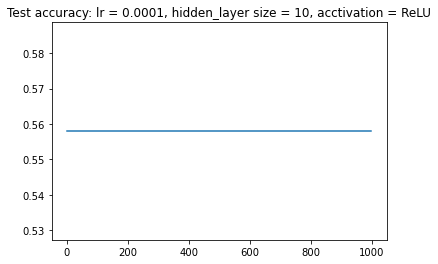

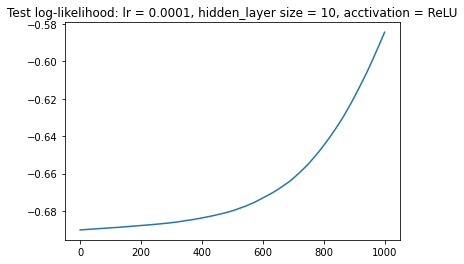

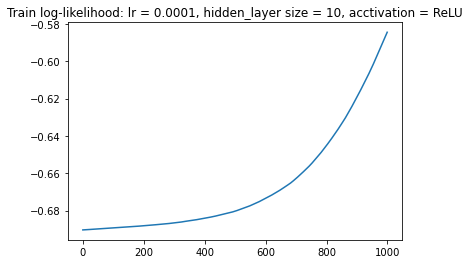

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  1246.506591796875
learning rate:0.0001
Train accuracy for iteration 999 is 0.7766456422018347
Predictive log-likelihood for train at iteration 999 is -0.48129773139953613
Test accuracy is 0.7896819999999983
Predictive log-likelihood for test at iteration 999 is -0.4780844748020172


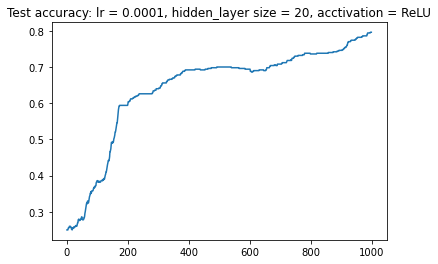

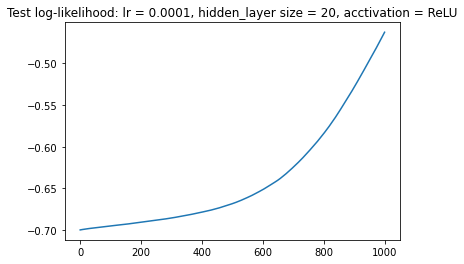

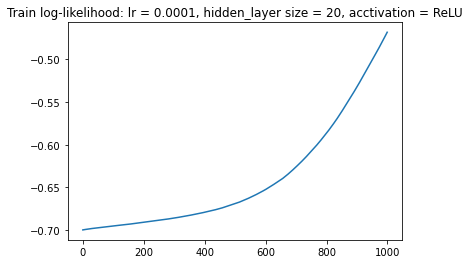

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  4484.98974609375
learning rate:0.0001
Train accuracy for iteration 999 is 0.963075688073393
Predictive log-likelihood for train at iteration 999 is -0.16752967238426208
Test accuracy is 0.9592080000000026
Predictive log-likelihood for test at iteration 999 is -0.1645950824022293


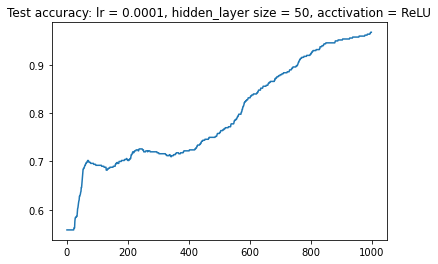

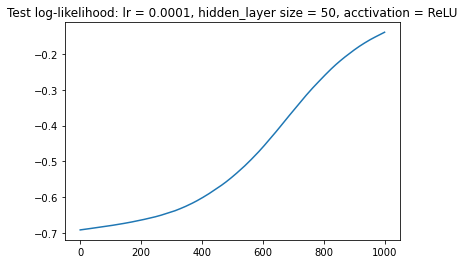

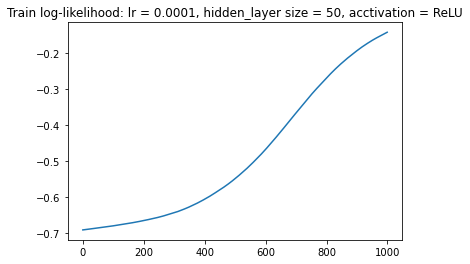

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  879.119384765625
learning rate:1e-05
Train accuracy for iteration 999 is 0.5382167431192661
Predictive log-likelihood for train at iteration 999 is -0.6908918619155884
Test accuracy is 0.5294520000000001
Predictive log-likelihood for test at iteration 999 is -0.6910707950592041


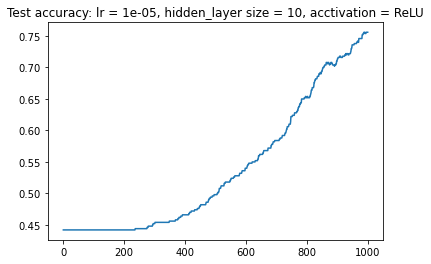

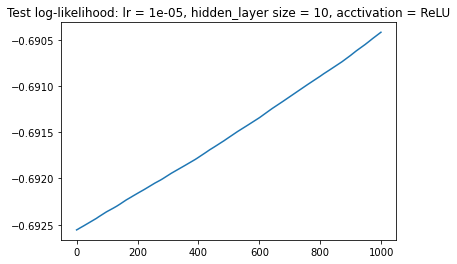

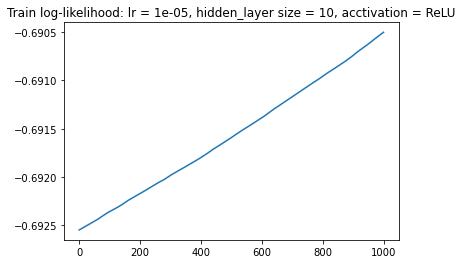

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  1465.3895263671875
learning rate:1e-05
Train accuracy for iteration 999 is 0.5283692660550459
Predictive log-likelihood for train at iteration 999 is -0.6912561655044556
Test accuracy is 0.5339760000000006
Predictive log-likelihood for test at iteration 999 is -0.6910525560379028


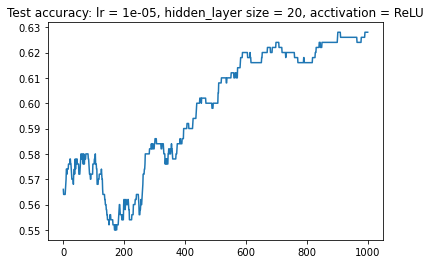

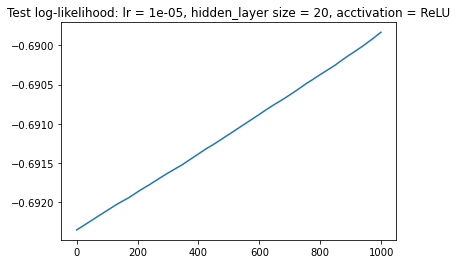

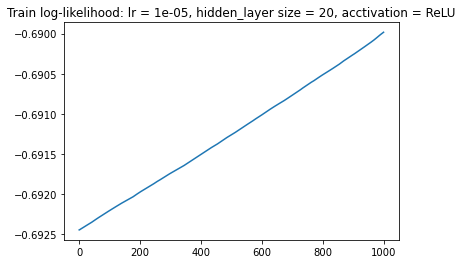

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  5044.5390625
learning rate:1e-05
Train accuracy for iteration 999 is 0.5913176605504626
Predictive log-likelihood for train at iteration 999 is -0.6774628758430481
Test accuracy is 0.5855739999999974
Predictive log-likelihood for test at iteration 999 is -0.6786054372787476


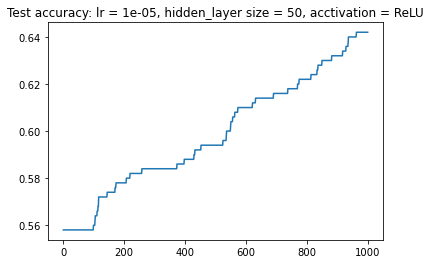

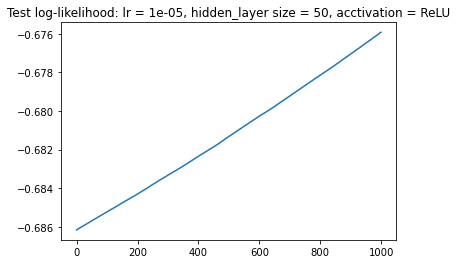

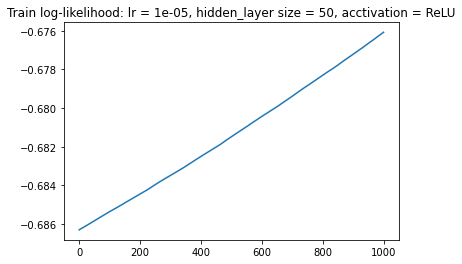

---------------------------------------------------------------------
---------------------------------------------------------------------


In [17]:
models = []
for lr in [1e-3, 0.5e-3, 1e-4, 1e-5]:
    for l in [10,20,50]:
        
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model = BNN(train, label, [5, l, l, 1], act = nn.ReLU(), n_epochs = 1000)
        model.train(lr = lr, decay = 1)
        models.append(model)
        _plot_(model.hist_acc, 
               title = "Test accuracy: lr = {}, hidden_layer size = {}, acctivation = ReLU".format(lr, l))
        _plot_(model.hist_llh_test, 
               title = "Test log-likelihood: lr = {}, hidden_layer size = {}, acctivation = ReLU".format(lr, l))
        _plot_(model.hist_llh_train, 
               title = "Train log-likelihood: lr = {}, hidden_layer size = {}, acctivation = ReLU".format(lr, l))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')

---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  274.4203186035156
learning rate:0.001
Train accuracy for iteration 999 is 0.9866422018348678
Predictive log-likelihood for train at iteration 999 is -0.03853880241513252
Test accuracy is 0.9866560000000081
Predictive log-likelihood for test at iteration 999 is -0.03908587992191315


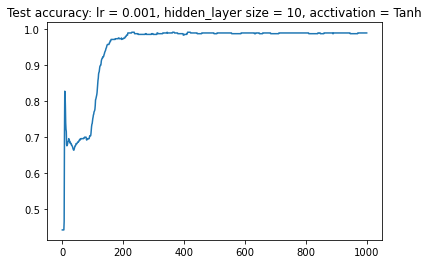

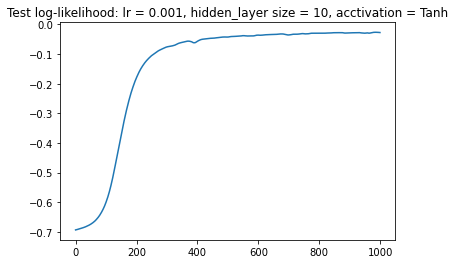

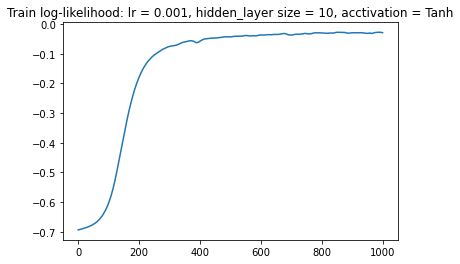

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  690.5307006835938
learning rate:0.001
Train accuracy for iteration 999 is 0.9911330275229402
Predictive log-likelihood for train at iteration 999 is -0.025059139356017113
Test accuracy is 0.9907440000000027
Predictive log-likelihood for test at iteration 999 is -0.0263664573431015


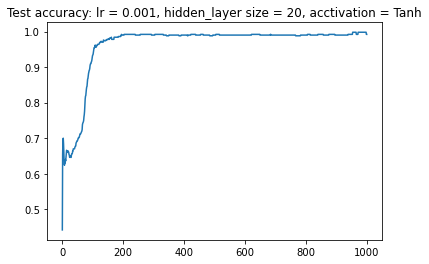

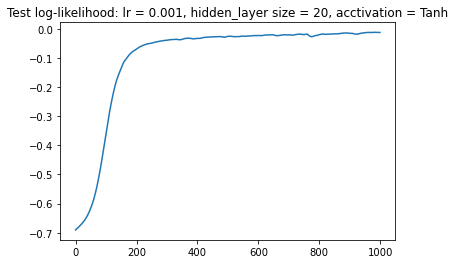

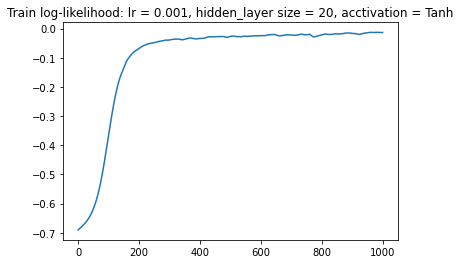

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.001 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  3314.423095703125
learning rate:0.001
Train accuracy for iteration 999 is 0.9926330275229389
Predictive log-likelihood for train at iteration 999 is -0.02110319398343563
Test accuracy is 0.9920260000000033
Predictive log-likelihood for test at iteration 999 is -0.022924313321709633


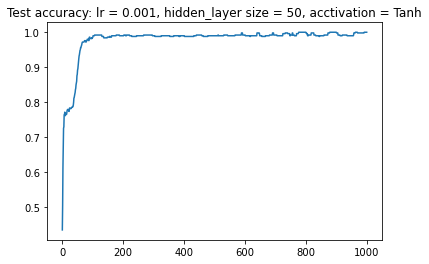

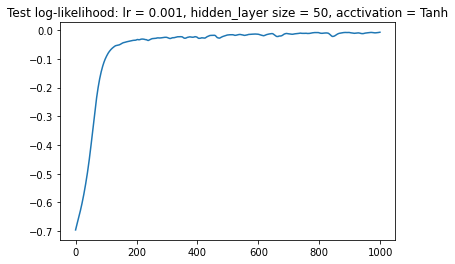

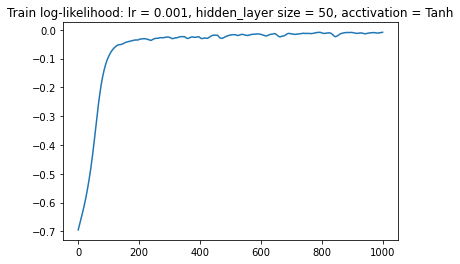

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  310.59613037109375
learning rate:0.0005
Train accuracy for iteration 999 is 0.9858853211009208
Predictive log-likelihood for train at iteration 999 is -0.05344266816973686
Test accuracy is 0.9857940000000103
Predictive log-likelihood for test at iteration 999 is -0.05496300011873245


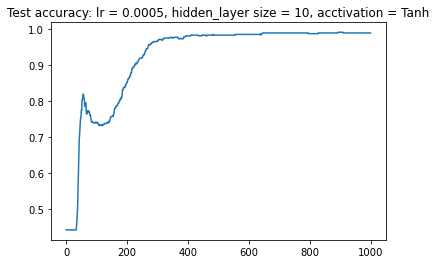

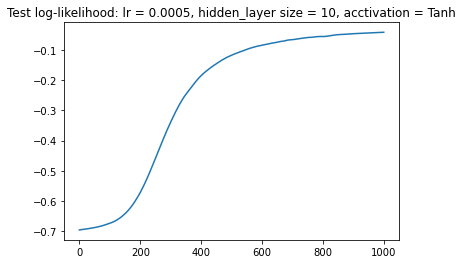

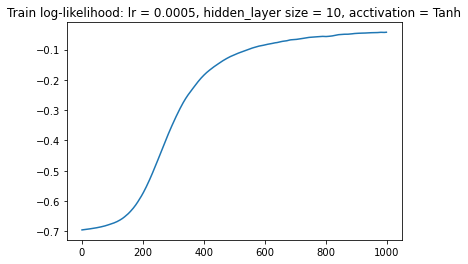

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  806.8530883789062
learning rate:0.0005
Train accuracy for iteration 999 is 0.9864655963302792
Predictive log-likelihood for train at iteration 999 is -0.03908579796552658
Test accuracy is 0.9860220000000091
Predictive log-likelihood for test at iteration 999 is -0.040934741497039795


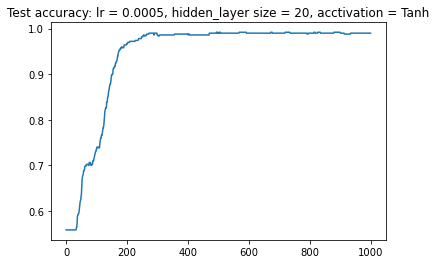

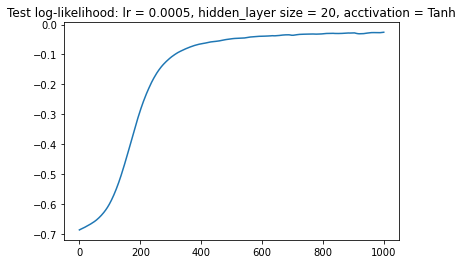

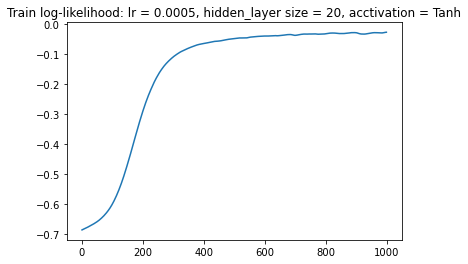

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0005 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  3924.336181640625
learning rate:0.0005
Train accuracy for iteration 999 is 0.9891548165137647
Predictive log-likelihood for train at iteration 999 is -0.028890211135149002
Test accuracy is 0.9895160000000075
Predictive log-likelihood for test at iteration 999 is -0.02927180379629135


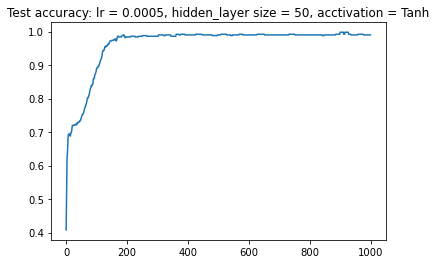

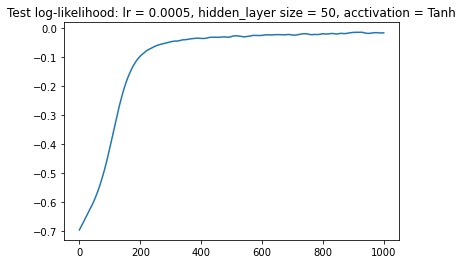

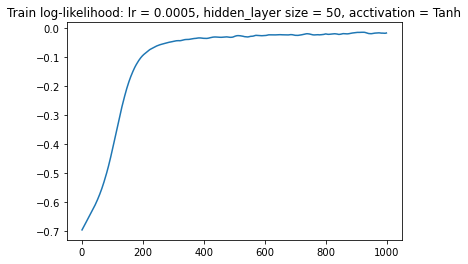

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  757.240478515625
learning rate:0.0001
Train accuracy for iteration 999 is 0.8757809633027515
Predictive log-likelihood for train at iteration 999 is -0.5407130718231201
Test accuracy is 0.8689279999999993
Predictive log-likelihood for test at iteration 999 is -0.5360708832740784


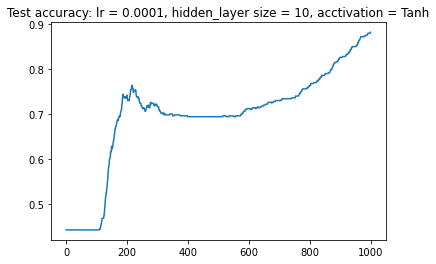

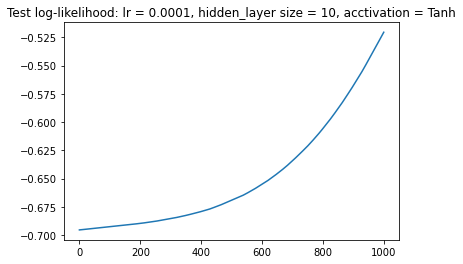

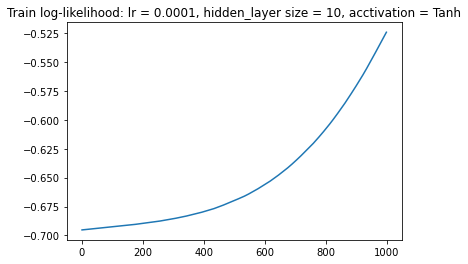

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  1111.9691162109375
learning rate:0.0001
Train accuracy for iteration 999 is 0.9618337155963309
Predictive log-likelihood for train at iteration 999 is -0.3221065104007721
Test accuracy is 0.9592420000000023
Predictive log-likelihood for test at iteration 999 is -0.3205154538154602


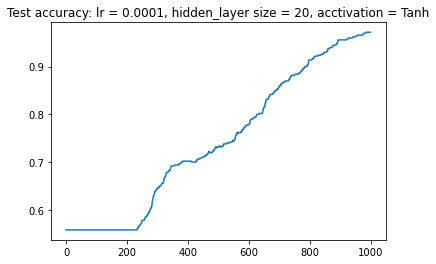

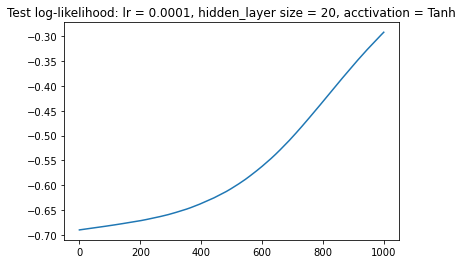

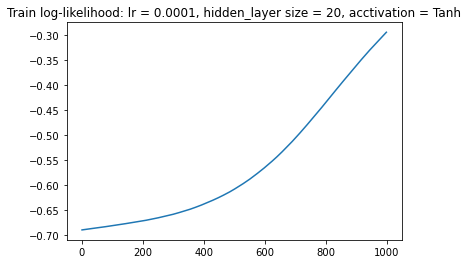

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 0.0001 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  4432.89111328125
learning rate:0.0001
Train accuracy for iteration 999 is 0.9788325688073413
Predictive log-likelihood for train at iteration 999 is -0.10938572138547897
Test accuracy is 0.9790400000000036
Predictive log-likelihood for test at iteration 999 is -0.11390221118927002


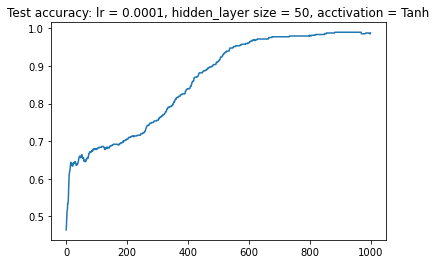

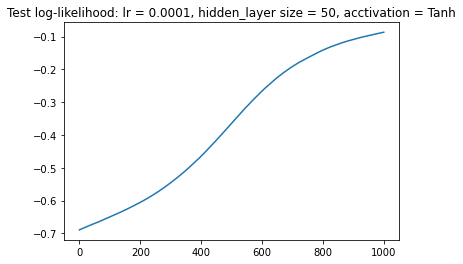

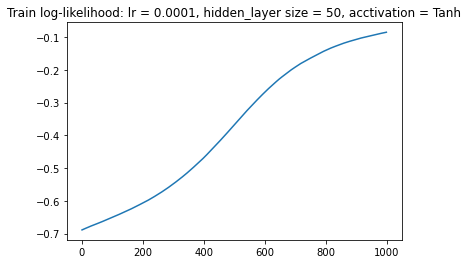

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 10


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  882.3837890625
learning rate:1e-05
Train accuracy for iteration 999 is 0.5584094036697287
Predictive log-likelihood for train at iteration 999 is -0.6884471774101257
Test accuracy is 0.5606279999999978
Predictive log-likelihood for test at iteration 999 is -0.6882408857345581


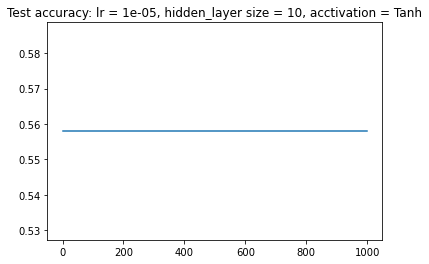

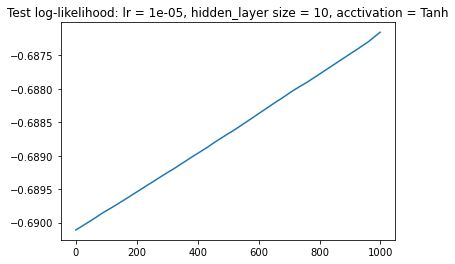

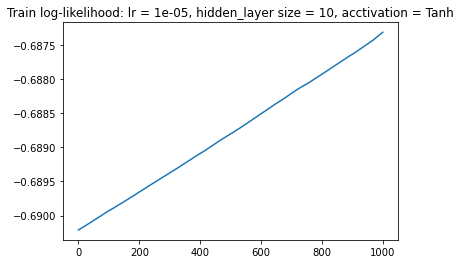

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 20


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  1453.701904296875
learning rate:1e-05
Train accuracy for iteration 999 is 0.6301582568807328
Predictive log-likelihood for train at iteration 999 is -0.6824323534965515
Test accuracy is 0.6279739999999997
Predictive log-likelihood for test at iteration 999 is -0.6816315054893494


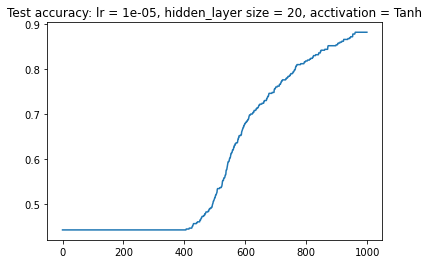

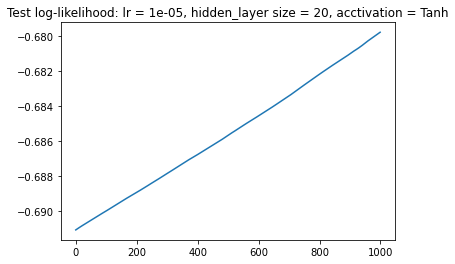

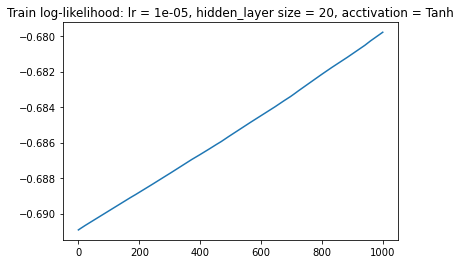

---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------


 Start training for lr = 1e-05 and hidden_layer size = 50


---------------------------------------------------------------------
---------------------------------------------------------------------
Loss:  4999.64453125
learning rate:1e-05
Train accuracy for iteration 999 is 0.7327901376146779
Predictive log-likelihood for train at iteration 999 is -0.65716952085495
Test accuracy is 0.726578
Predictive log-likelihood for test at iteration 999 is -0.6579870581626892


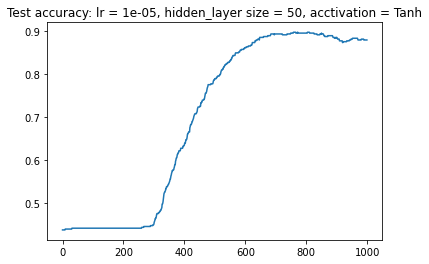

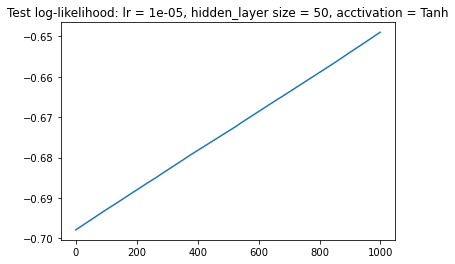

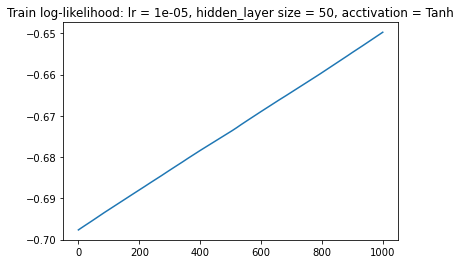

---------------------------------------------------------------------
---------------------------------------------------------------------


In [18]:
models2 = []
for lr in [1e-3, 0.5e-3, 1e-4, 1e-5]:
    for l in [10,20,50]:
        
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        print(colored("\n\n Start training for lr = {} and hidden_layer size = {}\n\n".format(lr, l), 'green'))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')
        model = BNN(train, label, [5, l, l, 1], act = nn.Tanh(), n_epochs = 1000)
        model.train(lr = lr, decay = 1)
        models2.append(model)
        _plot_(model.hist_acc, 
               title = "Test accuracy: lr = {}, hidden_layer size = {}, acctivation = Tanh".format(lr, l))
        _plot_(model.hist_llh_test, 
               title = "Test log-likelihood: lr = {}, hidden_layer size = {}, acctivation = Tanh".format(lr, l))
        _plot_(model.hist_llh_train, 
               title = "Train log-likelihood: lr = {}, hidden_layer size = {}, acctivation = Tanh".format(lr, l))
        print('---------------------------------------------------------------------')
        print('---------------------------------------------------------------------')